In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def load_snp_csv(snp_file):
    df = pd.read_csv(snp_file)  # do NOT use index_col=0 here
    df.rename(columns={df.columns[0]: 'GID'}, inplace=True)  # First column is GID
    df = df.astype(float, errors='ignore')  # Only SNPs will be float
    return df

class MultiModalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_path, geno_feature_cols, batch_size=32, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_path = image_path
        self.geno_feature_cols = geno_feature_cols
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        
        X_img = []
        X_geno = []
        Y = []
        
        for _, row in batch_df.iterrows():
            # Load image
            img = np.load(os.path.join(self.image_path, row['Filename']))
            X_img.append(img)

            # Genomic features
            geno = row[self.geno_feature_cols].values.astype(np.float32)
            X_geno.append(geno)

            # Yield
            Y.append(row['GRYLD'])

        return [np.array(X_img), np.array(X_geno)], np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [3]:
geno_df = load_snp_csv("SNPs_phased_reduced.csv")

In [4]:
#from sklearn.preprocessing import StandardScaler
#
## Drop GID column for scaling
#geno_features_only = geno_df.drop(columns=['GID'])
#
## Scale
#scaler = StandardScaler()
#geno_scaled = pd.DataFrame(
#    scaler.fit_transform(geno_features_only),
#    index=geno_df.index,
#    columns=geno_features_only.columns
#)
#
## Optionally, add GID back
#geno_scaled['GID'] = geno_df['GID']
#geno_scaled = geno_scaled[['GID'] + list(geno_features_only.columns)]



In [5]:
#geno_df = geno_scaled

In [6]:
#from sklearn.feature_selection import VarianceThreshold
#
#selector = VarianceThreshold(threshold=0.01)
#filtered_array = selector.fit_transform(geno_features_only)
#
## Rebuild dataframe
#filtered_snp_df = pd.DataFrame(filtered_array, index=geno_df.index, columns=geno_features_only.columns[selector.get_support()])

In [7]:
#geno_df = filtered_snp_df

In [4]:
csv_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/Images_GIDs_GRYLD.csv"
img_df = pd.read_csv(csv_path, header=None, names=['Filename', 'GID', 'GRYLD'])

In [5]:
# Load data
#geno_df = pd.read_csv('SNPs_phased_reduced.csv')
#img_df = pd.read_csv('Images_GIDs_GRYLD.csv')

# Reset index to make GID a column again
#geno_df_reset = geno_df.reset_index()

merged_df = pd.merge(img_df, geno_df, on='GID')

# Drop any NaNs
merged_df = merged_df.dropna(subset=['GRYLD'])

# Define genomic columns
geno_feature_cols = [col for col in merged_df.columns if col not in ['GID', 'Filename', 'GRYLD']]

image_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"


from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(merged_df, test_size=0.2, random_state=42)


# Create generator
train_gen = MultiModalDataGenerator(
    dataframe=train_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=True
)

val_gen = MultiModalDataGenerator(
    dataframe=val_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=False  # don't shuffle validation
)

In [8]:
# Alignment check

# Display a few rows to check alignment
sample = merged_df.sample(1).iloc[0]
print(f"GID: {sample['GID']}")
print(f"Filename: {sample['Filename']}")
print(f"Yield (GRYLD): {sample['GRYLD']:.3f}")

# Check genotype vector
geno_vector = sample[geno_feature_cols].values
print(f"Genotype shape: {geno_vector.shape}")
print(f"Non-zero SNPs: {(geno_vector != 0).sum()}, Mean: {geno_vector.mean():.4f}")

GID: GID8237985
Filename: 18-OBR-YTBW-B5I-7626-20180315_214453_IMG_0841_1.npy
Yield (GRYLD): 6.903
Genotype shape: (84322,)
Non-zero SNPs: 10152, Mean: 0.1146


In [6]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

# Load and rename image model
image_model = load_model('CNN.h5', compile=False)
image_model._name = 'image_model'  # Rename to avoid name clash

# Load and rename genotype model
geno_model = load_model('wheat_height_predictor.h5', compile=False)
geno_model._name = 'geno_model'  # Rename to avoid name clash

# Freeze both models
for layer in image_model.layers:
    layer.trainable = False
for layer in geno_model.layers:
    layer.trainable = False

# Define new inputs
img_input = Input(shape=image_model.input_shape[1:], name='image_input')
geno_input = Input(shape=geno_model.input_shape[1:], name='geno_input')

# Pass through models
img_features = image_model(img_input)
geno_features = geno_model(geno_input)

# Combine
fusion = concatenate([img_features, geno_features], name='fusion')
x = layers.Dense(128, activation='relu', name='fusion_dense_1')(fusion)
x = layers.Dropout(0.3, name='fusion_dropout_1')(x)
x = layers.Dense(64, activation='relu', name='fusion_dense_2')(x)
x = layers.Dropout(0.2, name='fusion_dropout_2')(x)
output = layers.Dense(1, activation='relu', name='yield_output')(x)   # setting this to 2 makes the model produce two outputs - incompatible with downstream analysis

# Final model
fusion_model = Model(inputs=[img_input, geno_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,         
    verbose=1
)

Epoch 1/30
4308/4308 [==============================] - 5524s 1s/step - loss: 0.9022 - mae: 0.6886 - val_loss: 0.0998 - val_mae: 0.2310
Epoch 2/30
4308/4308 [==============================] - 5505s 1s/step - loss: 0.4192 - mae: 0.5094 - val_loss: 0.0921 - val_mae: 0.2180
Epoch 3/30
4308/4308 [==============================] - 5727s 1s/step - loss: 0.3041 - mae: 0.4316 - val_loss: 0.0915 - val_mae: 0.2169
Epoch 4/30
4308/4308 [==============================] - 5638s 1s/step - loss: 0.2261 - mae: 0.3675 - val_loss: 0.0932 - val_mae: 0.2188
Epoch 5/30
4308/4308 [==============================] - 5761s 1s/step - loss: 0.1769 - mae: 0.3199 - val_loss: 0.0924 - val_mae: 0.2177
Epoch 6/30
4308/4308 [==============================] - 5811s 1s/step - loss: 0.1463 - mae: 0.2866 - val_loss: 0.0865 - val_mae: 0.2090
Epoch 7/30
4308/4308 [==============================] - 5912s 1s/step - loss: 0.1262 - mae: 0.2640 - val_loss: 0.0815 - val_mae: 0.2019
Epoch 8/30
4308/4308 [==========================

In [7]:
history = fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,         
    verbose=1
)

Epoch 1/20
4308/4308 [==============================] - 5327s 1s/step - loss: 0.8452 - mae: 0.6961 - val_loss: 0.1322 - val_mae: 0.2733
Epoch 2/20
4308/4308 [==============================] - 5491s 1s/step - loss: 0.3780 - mae: 0.4822 - val_loss: 0.1035 - val_mae: 0.2319
Epoch 3/20
4308/4308 [==============================] - 5571s 1s/step - loss: 0.2898 - mae: 0.4189 - val_loss: 0.0981 - val_mae: 0.2243
Epoch 4/20
4308/4308 [==============================] - 5580s 1s/step - loss: 0.2300 - mae: 0.3703 - val_loss: 0.1104 - val_mae: 0.2481
Epoch 5/20
4308/4308 [==============================] - 5556s 1s/step - loss: 0.1878 - mae: 0.3317 - val_loss: 0.0937 - val_mae: 0.2179
Epoch 6/20
4308/4308 [==============================] - 5559s 1s/step - loss: 0.1585 - mae: 0.3012 - val_loss: 0.0894 - val_mae: 0.2152
Epoch 7/20
4308/4308 [==============================] - 5609s 1s/step - loss: 0.1438 - mae: 0.2851 - val_loss: 0.0898 - val_mae: 0.2155
Epoch 8/20
4308/4308 [==========================

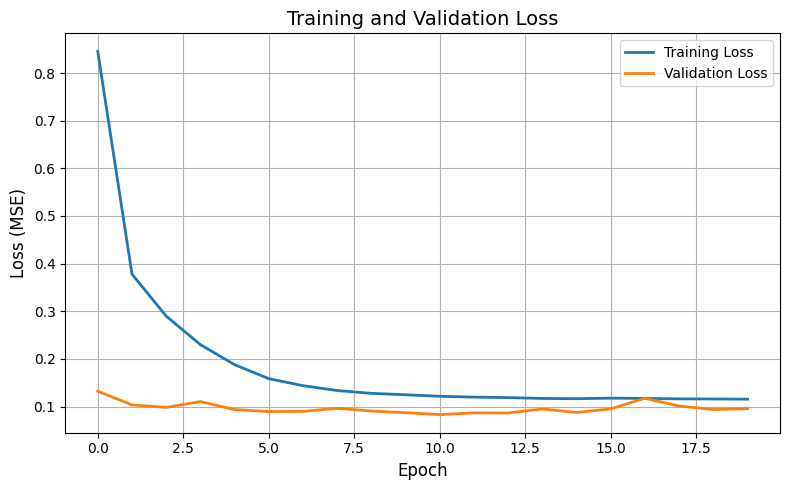

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result from model.fit()
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import r2_score

y_pred_train = fusion_model.predict(train_gen)

y_true_train = np.concatenate([y for _, y in train_gen])

r2_train = r2_score(y_true_train, y_pred_train)
print(f"R² score: {r2_train:.4f}")

4308/4308 [==============================] - 4501s 1s/step
R² score: -0.5751


In [ ]:
# Disable shuffling in train_gen to make it deterministic
train_gen.shuffle = False
train_gen.on_epoch_end()  # Re-shuffle once manually if needed

# Predict on the whole generator
y_pred_train = fusion_model.predict(train_gen, verbose=1)

# Collect y_true **in sync**
y_true_train = []
for i in range(len(train_gen)):
    _, y = train_gen[i]
    y_true_train.append(y)
y_true_train = np.concatenate(y_true_train)

# Compute R²
from sklearn.metrics import r2_score
r2_train = r2_score(y_true_train, y_pred_train)
print(f"R² score (synced): {r2_train:.4f}")

 113/4308 [..............................] - ETA: 1:03:50

In [12]:
from sklearn.metrics import r2_score

y_pred_val = fusion_model.predict(val_gen)
y_true_val = np.concatenate([y for _, y in val_gen])

r2_val = r2_score(y_true_val, y_pred_val)
print(f"Validation R²: {r2_val:.4f}")

1077/1077 [==============================] - 1102s 1s/step
Validation R²: 0.8176


In [13]:
fusion_model.save('Multimodal.h5')

In [15]:
print("Predicted range:", y_pred_train.min(), "to", y_pred_train.max())
print("True range:", y_true_train.min(), "to", y_true_train.max())

Predicted range: 1.2519693 to 10.0894375
True range: 0.861 to 10.192


In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title('Predicted vs True GRYLD')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'y_true' is not defined

<Figure size 600x600 with 0 Axes>

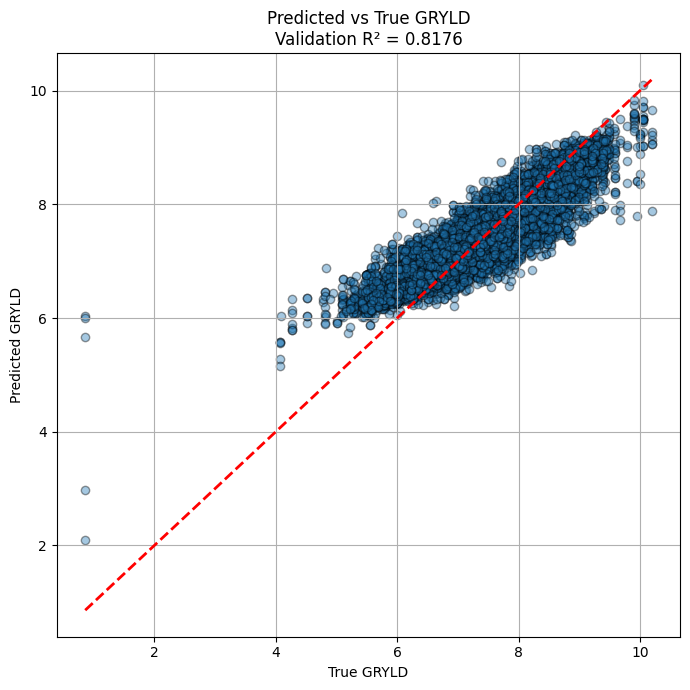

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_true_val, y_pred_val, alpha=0.4, edgecolors='k')
plt.plot([y_true_val.min(), y_true_val.max()],
         [y_true_val.min(), y_true_val.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nValidation R² = {r2_val:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

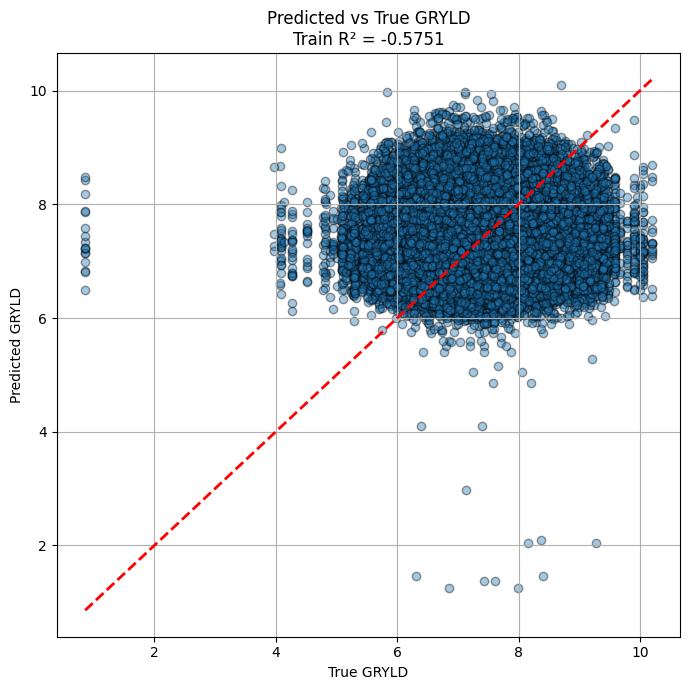

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(y_true_train, y_pred_train, alpha=0.4, edgecolors='k')
plt.plot([y_true_train.min(), y_true_train.max()],
         [y_true_train.min(), y_true_train.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nTrain R² = {r2_train:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Predict on only the first N batches
N = 1000  # test with 3 batches first (or however many fit in memory/time)
y_true_all = []
y_pred_all = []

for i in range(N):
    (X_img, X_geno), y_true = train_gen[i]
    y_pred = fusion_model.predict([X_img, X_geno], verbose=0)
    y_true_all.append(y_true)
    y_pred_all.append(y_pred.flatten())

# Flatten and compute R²
from sklearn.metrics import r2_score
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)
print(f"Quick R²: {r2:.4f} (on {len(y_true_all)} samples)")

Quick R²: 0.8153 (on 32000 samples)


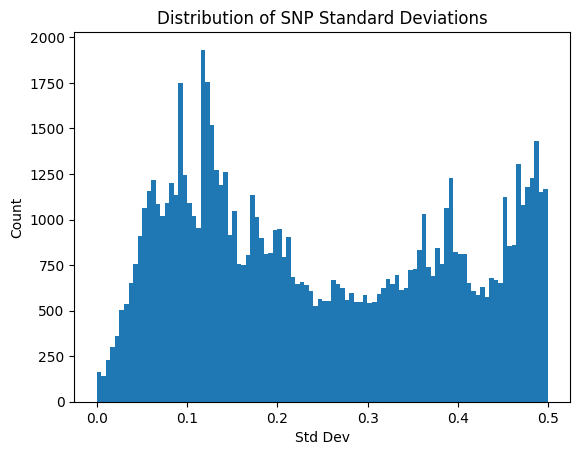

In [11]:
import matplotlib.pyplot as plt
geno_std = merged_df[geno_feature_cols].std(axis=0)
plt.hist(geno_std, bins=100)
plt.title("Distribution of SNP Standard Deviations")
plt.xlabel("Std Dev")
plt.ylabel("Count")
plt.show()

In [7]:
fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    steps_per_epoch=500,
    validation_steps=200, 
    verbose=1
)

Epoch 1/30
500/500 [==============================] - 733s 1s/step - loss: 4.1400 - mae: 1.3186 - val_loss: 0.1350 - val_mae: 0.2782
Epoch 2/30
500/500 [==============================] - 726s 1s/step - loss: 0.9422 - mae: 0.7723 - val_loss: 0.1157 - val_mae: 0.2511
Epoch 3/30
500/500 [==============================] - 752s 2s/step - loss: 0.7855 - mae: 0.7044 - val_loss: 0.0998 - val_mae: 0.2298
Epoch 4/30
500/500 [==============================] - 727s 1s/step - loss: 0.7114 - mae: 0.6669 - val_loss: 0.1040 - val_mae: 0.2379
Epoch 5/30
500/500 [==============================] - 718s 1s/step - loss: 0.6727 - mae: 0.6500 - val_loss: 0.0915 - val_mae: 0.2207
Epoch 6/30
500/500 [==============================] - 768s 2s/step - loss: 0.6237 - mae: 0.6267 - val_loss: 0.0898 - val_mae: 0.2213
Epoch 7/30
500/500 [==============================] - 747s 1s/step - loss: 0.6115 - mae: 0.6197 - val_loss: 0.0985 - val_mae: 0.2312
Epoch 8/30
500/500 [==============================] - 735s 1s/step - 